Credit of the code: https://emcee.readthedocs.io/en/stable/tutorials/line/

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Loading data

In [4]:
# ID, x, y, s_y, s_x, r_xy
Table1 = np.array([[1,  201, 592, 61, 9,  -0.84],
[2,  244, 401, 25, 4,  0.31],
[3,  47,  583, 38, 11, 0.64],
[4,  287, 402, 15, 7,  -0.27],
[5,  203, 495, 21, 5,  -0.33],
[6,  58,  173, 15, 9,  0.67],
[7,  210, 479, 27, 4,  -0.02],
[8,  202, 504, 14, 4,  -0.05],
[9,  198, 510, 30, 11, -0.84],
[10, 158, 416, 16, 7,  -0.69],
[11, 165, 393, 14, 5,  0.30],
[12, 201, 442, 25, 5,  -0.46],
[13, 157, 317, 52, 5,  -0.03],
[14, 131, 311, 16, 6,  0.50],
[15, 166, 400, 34, 6,  0.73],
[16, 160, 337, 31, 5,  -0.52],
[17, 186, 423, 42, 9,  0.90],
[18, 125, 334, 26, 8,  0.40],
[19, 218, 533, 16, 6,  -0.78],
[20, 146, 344, 22, 5,  -0.56]])

m=2.2399208316310926,b=34.047727757542816


(0.0, 700.0)

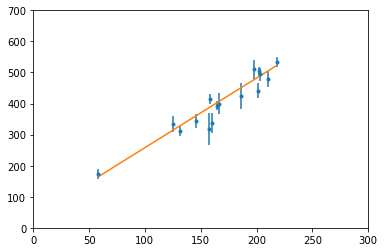

In [5]:
### lstandard linear algebra method from Example 1.

x = Table1[4:,1]
y = Table1[4:,2]
sy = Table1[4:,3]

A = np.c_[x/x,x]

C = np.eye(sy.size)*(sy**2)

AT_Cinv_A = (A.T).dot(np.linalg.inv(C).dot(A))
AT_Cinv_Y = (A.T).dot(np.linalg.inv(C).dot(y))

b_1,m_1 =  np.linalg.inv(AT_Cinv_A).dot(AT_Cinv_Y)

print(f'm={m_1},b={b_1}')

plt.figure()

plt.errorbar(x,y, yerr=sy, fmt='.')
x = np.sort(x)
plt.plot(x,m_1*x+b_1)

plt.xlim(0,300)
plt.ylim(0,700)

### Exercise 6:
Using the mixture model proposed above—that treats the
distribution as a mixture of a thin line containing a fraction [1−Pb]
of the points and a broader Gaussian containing a fraction Pb of the
points—find the best- fit (the maximum a posteriori) straight line
y = m x + b for the x, y, and σy for the data in Table 1 on page 6.
Before choosing the MAP line, marginalize over parameters (Pb, Yb, Vb).
That is, if you take a sampling approach, this means sampling the full
five-dimensional parameter space but then choosing the peak value in
the histogram of samples in the two-dimensional parameter space (m, b).
Make one plot showing this two-dimensional histogram, and another
showing the points, their uncertainties, and the MAP line. How does
this compare to the standard result you obtained in Exercise 2? Do you
like the MAP line better or worse? For extra credit, plot a sampling
of 10 lines drawn from the marginalized posterior distribution for
(m, b) (marginalized over Pb,Yb,Vb) and plot the samples as a set of
light grey or transparent lines. Your plot should look like Figure 4.

In [6]:
x = Table1[:,1]
y = Table1[:,2]
yerr = sy = Table1[:,3]

# x = Table1[4:,1]
# y = Table1[4:,2]
# sy = yerr = Table1[4:,3]

In [7]:
import emcee
import corner




In [8]:
def log_likelihood(x,y,sy,theta):
    """
    theta = [m, b, Pb, Yb, Vb]
    where m,b are the model parameters, and 
    Pb, Yb, Vb, are nuisance parameters that we will marginalize over.
    """
    m,b,Pb,Yb,Vb = theta


    # data model
    _pd = (1-Pb) * np.exp(-0.5*((y-m*x-b)/sy)**2) / np.sqrt(2*np.pi*sy**2)
    # background model
    _pb = Pb * np.exp(-0.5*((y-Yb)**2/(Vb+sy**2))) / np.sqrt(2*np.pi*(Vb+sy**2))
    
    return np.log(_pd + _pb).sum()

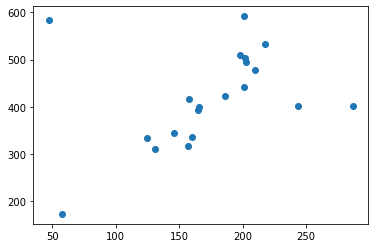

In [9]:
plt.scatter(x,y)

In [10]:
def log_prior(theta):
    m,b,Pb,Yb,Vb = theta

    _mr = [-5,5]
    _br = [-50,500]
    _Pbr = [0,1]
    _Ybr = [-50,500]
    _Vbr = [0,150]
    
    mb_if = (_mr[0] < m < _mr[1]) and (_br[0] < b < _br[1])
    Nuisance_if = (_Pbr[0] < Pb < _Pbr[1]) and (_Ybr[0] < Yb < _Ybr[1]) and (_Vbr[0] < Vb < _Vbr[1])

    
    _rlist = [_mr, _br, _Pbr, _Ybr, _Vbr]
    norm = sum([np.abs(_r).sum() for _r in _rlist])
    
    if mb_if and Nuisance_if:
        return 1/norm
    return -np.inf

In [11]:
# def log_probability(x,y,sy,theta):
def log_probability(theta, x, y, yerr):  
    """
    theta = [m, b, Pb, Yb, Vb]
    where m,b are the model parameters, and 
    Pb, Yb, Vb, are nuisance parameters that we will marginalize over.
    """
    m,b,Pb,Yb,Vb = theta
    
    lp = log_prior(theta)
    if ~np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(x,y,sy,theta)
    

In [12]:
m,b = -4,4
Pb, Yb, Vb = 0.1,20,20
theta = [m, b, Pb, Yb, Vb]
log_probability(theta, x,y,sy)

-3520.657926708412

In [13]:
initial_pos = np.array([2,30,0.05,400,75])*(1+0.2*np.random.normal(size=(10,5)))

nwalkers, ndim = initial_pos.shape



In [14]:
from multiprocessing import Pool

In [15]:
with Pool(processes=8) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr),pool=pool)
    
    sampler.run_mcmc(initial_pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/koppelman/opt/anaconda3/envs/gold/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:16<00:00, 603.00it/s]


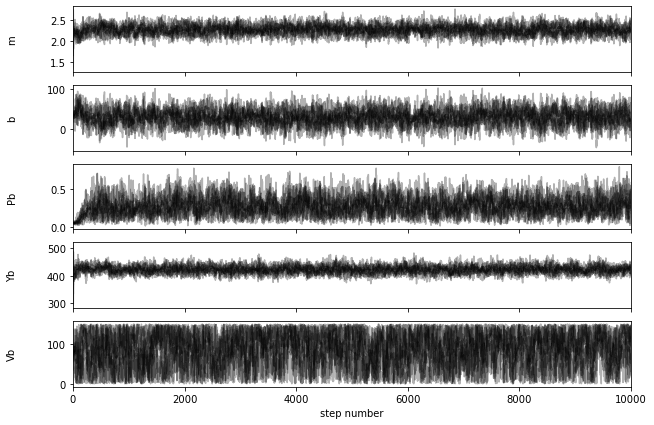

In [16]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['m','b','Pb','Yb','Vb']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [17]:
tau = sampler.get_autocorr_time()
print(tau)

[75.69151073 75.39550942 92.60657954 68.36398457 78.64793423]


In [18]:
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

(1980, 5)


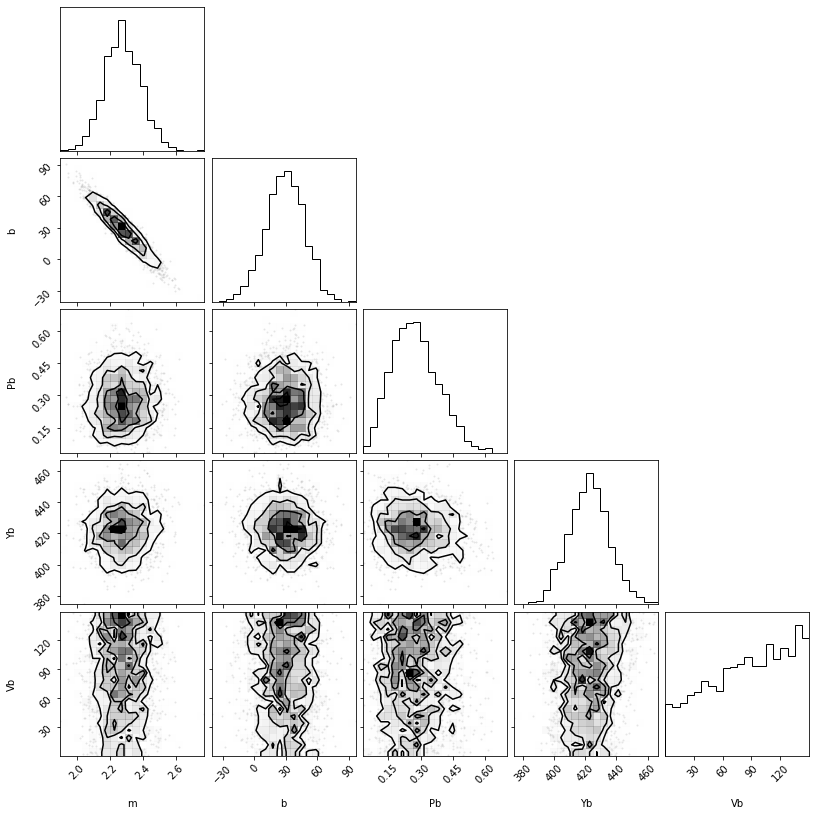

In [19]:

fig = corner.corner(
    flat_samples, labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);

In [20]:
x0 = np.linspace(50, 300, 500)

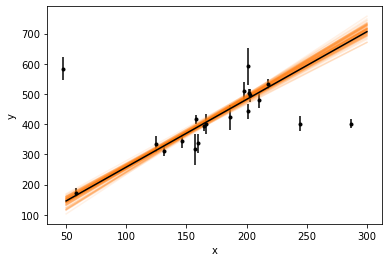

In [21]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)


plt.plot(x0,m_1*x0+b_1, c='k')


plt.xlabel("x")
plt.ylabel("y");

In [22]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Exercise 9: 
Re-do Exercise 6—the mixture-based outlier model—but just with the “inlier” points 5 through 20 from Table 1 on page 6. Then do the same again, but with all measurement uncertainties reduced by a factor of 2 (uncertainty variances reduced by a factor of 4). Plot the marginal- ized posterior probability distributions for line parameters (m,b) in both cases. Your plots should look like those in Figure 6. Did these posterior distributions get smaller or larger with the reduction in the data-point un-
certainties? Compare this with the dependence of the standard uncertainty
􏰀 ⊤ −1 􏰁−1 estimate A C A .

meh.